<a href="https://colab.research.google.com/github/KsNikko27/Woirk_files_transfer/blob/main/Lesson_2_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Вспомогательный код
*Запустите клетку ниже перед началом работы*

In [1]:
#@title 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, Normalize
from sklearn.metrics import accuracy_score


%matplotlib inline
np.random.seed(10)

colors = ['red', "blue"]
labels_cmap = ListedColormap(colors, 2)
colors = [(1, 0, 0), (1, 1, 1), (0, 0, 1)]  # R -> W -> B
main_cmap = LinearSegmentedColormap.from_list("main_scheme", colors, N=300)

def show_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y))
    
def generate_simple_data(N, a, b, c, max_x=5, max_y=5):
    np.random.seed(10)
    X = np.random.rand(N, 2)
    X[:, 0] = X[:, 0] * max_x
    X[:, 1] = X[:, 1] * max_y
    y = np.zeros(N)
    y[X[:, 0] * a + X[:, 1] * b + c > 0] = 1
    #y[X[:, 0] * a + X[:, 1] * b + c < -m]= 0
    return X, y

def create_neuron(a, b, c, prob_output=False):
    if prob_output:
        return lambda x: sigmoid(a*x[:, 0] + b*x[:, 1] + c)
    else:
        return lambda x: a*x[:, 0] + b*x[:, 1] + c

def show_descision_boundary(clf, limits, binary=False, X=None, y=None, n_lines=10, show_lines=False,
                           figsize=(5, 5), ax=None):
    xs, ys = limits
    x_min, x_max = xs
    y_min, y_max = ys
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1, 1, 1)
    
    if binary:
        Z = clf.predict_class(np.c_[xx.ravel(), xx.ravel()])
        Z = clf.predict_class(np.c_[xx.ravel(), yy.ravel()])
        norm = Normalize(vmin=0.,vmax=1.)
    else:
        Z = clf(np.c_[xx.ravel(), xx.ravel()])
        Z = clf(np.c_[xx.ravel(), yy.ravel()])
        if clf.prob_output:
            norm = Normalize(vmin=0.,vmax=1.)
        else:
            norm = Normalize(vmin=-10.,vmax=10., clip=True)
        
    Z = Z.reshape(xx.shape)
    Z = Z.astype(np.float32)
    
    ax.contourf(xx, yy, Z, n_lines, alpha=0.4, cmap=main_cmap, norm=norm)
    if show_lines:
        cp = ax.contour(xx, yy, Z, n_lines)
        ax.clabel(cp, inline=True, 
              fontsize=10, colors="green")
    
    if y is not None:
        X = np.array(X)
        y = np.array(y)
        ax.scatter(X[:, 0], X[:, 1], s=120, color=labels_cmap(y),
                   zorder=4)
        

def eval_clf(clf, X, y):
    acc = accuracy_score(clf.predict_class(X), y)
    print(f"Accuracy {acc}")
    return acc

def create_two_axes():
    fig = plt.figure(figsize=(11, 5))
    grid = plt.GridSpec(1, 2)
    values = fig.add_subplot(grid[0, 0])
    values.set_xlabel("$x_1$")
    values.set_ylabel("$x_2$")
    values.set_title("Выход классификатора (со значениями)")

    binary = fig.add_subplot(grid[0, 1])
    binary.set_xlabel("$x_1$")
    binary.set_ylabel("$x_2$")
    binary.set_title("Решающая поверхность")
    
    return values, binary

def sigmoid(x):
    return 1./(1.+np.exp(-x))


# реализация нейрона
class Neuron:
    def __init__(self, a, b, c, prob_output=True):
        self.a = a
        self.b = b
        self.c = c
        self.prob_output = prob_output
        
    def __call__(self, x: np.ndarray) -> np.ndarray:
        assert np.ndim(x) == 2 and x.shape[1] == 2
        if self.prob_output:
            return sigmoid(self.a * x[:, 0] + self.b * x[:,1] + self.c)
        else:
            return self.a * x[:, 0] + self.b * x[:,1] + self.c
    
    def predict_class(self, x: np.ndarray) -> np.ndarray:
        prediction = self.__call__(x)
        if self.prob_output:
            return (prediction > 0.5).astype(np.int32)
        else:
            return (prediction > 0.0).astype(np.int32)

# Линейный классификатор

В этом задании вы на практике "прочувствуете" как работает линейный классификатор, и выступите в роли оптимизатора -- пытаясь подобрать правильные параметры.

Для удобства и простоты визуализации мы будем работать с двумерным пространством  -- признаки $x_1, x_2$ и двумя классами -- $[0, 1]$. Класс 1 соответствует синему цвету, 0 -- красному.

Мы начнем практическое занятие с линейного классификатора, который будет иметь вид: $y = I[ax_1+bx_2+c > 0]$. 

Таким образом, имея коэффиценты $a, b, c$, для получения ответа на объекте --  точке с двумя координатами $\hat{x_1}, \hat{x_2}$ мы просто подставим все численные значения в выражение выше и сравним его значение с нулем.

Например при $a=3, b=-3, c=2$ точку $(2, 1)$ мы отнесем к синему классу ($3*2 -3 * 1 + 2 = 5 > 0$), а точку ($1, 4$) -- к красному ($3 * 1 -3*4 + 2 = -7 < 0$). Решающая поверхность для такого классификатора изображена ниже.

Напоминаем, что за "раскраску" в синий и красный отвечает нормаль. В ее направлении область будет синей, а в противоположном -- красной. В этом примере нормаль смотрит вниз вправо, т.к вектор нормали $(a,b) = (3, -3)$.


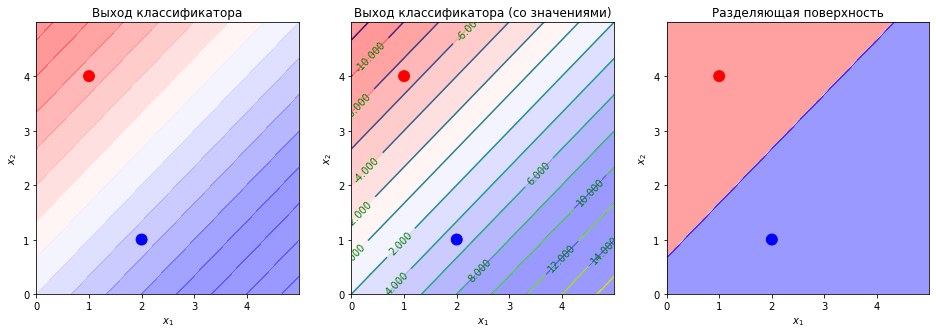

In [2]:
#@title Визуализация классификатора
clf1 = Neuron(a=3, b=-3, c=2, prob_output=False)
limits = limits=[[0, 5], [0, 5]]
X = [[2, 1], [1, 4]]
y = [1, 0]

fig = plt.figure(figsize=(16, 5))
grid = plt.GridSpec(1, 3)
no_values = fig.add_subplot(grid[0, 0])
no_values.set_xlabel("$x_1$")
no_values.set_ylabel("$x_2$")
no_values.set_title("Выход классификатора")

values = fig.add_subplot(grid[0, 1])
values.set_xlabel("$x_1$")
values.set_ylabel("$x_2$")
values.set_title("Выход классификатора (со значениями)")

binary = fig.add_subplot(grid[0, 2])
binary.set_xlabel("$x_1$")
binary.set_ylabel("$x_2$")
binary.set_title("Разделяющая поверхность")
show_descision_boundary(clf1, limits, n_lines=15, X=X, y=y, show_lines=False, ax=no_values)
show_descision_boundary(clf1, limits, n_lines=15, X=X, y=y, show_lines=True, ax=values)
show_descision_boundary(clf1, limits, binary=True, 
                        n_lines=15, X=X, y=y, show_lines=False, ax=binary)

**Задание 1** Ниже представлены три разные конфигурации данных. Ваша задача изменить параметры с помощью слайдеров таким образом, чтобы получить идеальное разбиение (accuracy = 100%). 

*Примечание: при первом запуске -- нажмите CTRL+ENTER, после чего все управление будет осуществляться бегунками. Менять код не нужно. Если код случайно отобразился -- можно для удобства спрятать его: три точки в правом верхнем углу клетки -> Form -> Hide Code*

Accuracy 1.0
Well done!


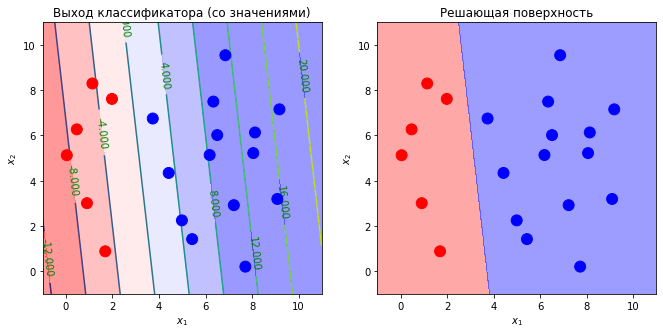

In [58]:
#@title 1a { run: "auto" }
a = 2.4 #@param {type:"slider", min:-10, max:10, step:0.1}
b = 0.3 #@param {type:"slider", min:-10, max:10, step:0.1}
c = -10 #@param {type:"slider", min:-10, max:10, step:0.1}

X, y = generate_simple_data(20, 1, 0, -2, 10, 10)

clf = Neuron(a=a, b=b, c=c, prob_output=False)
limits = [[-1, 11], [-1, 11]]

values, binary = create_two_axes()
if eval_clf(clf, X, y) != 1.:
    print("Try harder!")
else:
    print("Well done!")
    

show_descision_boundary(limits=limits, binary=False, clf=clf, 
                            X=X,
                            y=y, 
                            n_lines=10,
                           show_lines=True, ax=values)
show_descision_boundary(limits=limits, binary=True, clf=clf, 
                        X=X,
                        y=y, 
                        n_lines=7,
                       show_lines=False, ax=binary)

Accuracy 1.0
Well done!


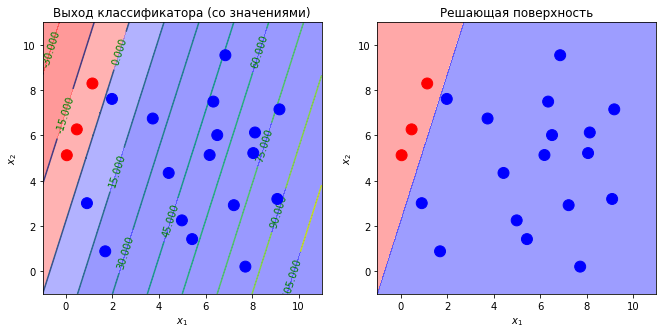

In [83]:
#@title 1b { run: "auto" }

a = 10 #@param {type:"slider", min:-10, max:10, step:0.1}
b = -3.1 #@param {type:"slider", min:-10, max:10, step:0.1}
c = 6.9 #@param {type:"slider", min:-10, max:10, step:0.1}

#n_lines = 15 #@param {type:"slider", min:0, max:50, step:1}
#show_lines = False #@param {type:"boolean"}
X, y = generate_simple_data(20, 3, -1, 2, 10, 10)
clf = Neuron(a, b, c, False)

values, binary = create_two_axes()
if eval_clf(clf, X, y) != 1.:
    print("Try harder!")
else:
    print("Well done!")
    

show_descision_boundary(limits=limits, binary=False, clf=clf, 
                            X=X,
                            y=y, 
                            n_lines=10,
                           show_lines=True, ax=values)
show_descision_boundary(limits=limits, binary=True, clf=clf, 
                        X=X,
                        y=y, 
                        n_lines=7,
                       show_lines=False, ax=binary)

Accuracy 1.0
Well done!


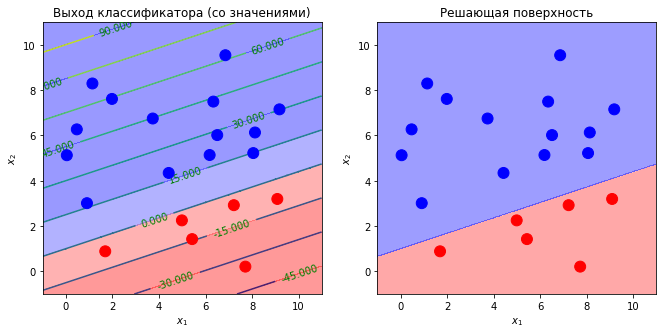

In [95]:
#@title 1c { run: "auto" }
n_lines = 5

a = -3.4 #@param {type:"slider", min:-10, max:10, step:0.1}
b = 10 #@param {type:"slider", min:-10, max:10, step:0.1}
c = -10 #@param {type:"slider", min:-10, max:10, step:0.1}

#n_lines = 15 #@param {type:"slider", min:0, max:50, step:1}
#show_lines = False #@param {type:"boolean"}
X, y = generate_simple_data(20, -1, 3, -2, 10, 10)
clf = Neuron(a, b, c, False)
clf_ = lambda x: clf(x) > 0.0

values, binary = create_two_axes()
if eval_clf(clf, X, y) != 1.:
    print("Try harder!")
else:
    print("Well done!")
    

show_descision_boundary(limits=limits, binary=False, clf=clf, 
                            X=X,
                            y=y, 
                            n_lines=10,
                           show_lines=True, ax=values)
show_descision_boundary(limits=limits, binary=True, clf=clf, 
                        X=X,
                        y=y, 
                        n_lines=7,
                       show_lines=False, ax=binary)

Accuracy 1.0
Classifier value at [6 2]: 35.8
Well done


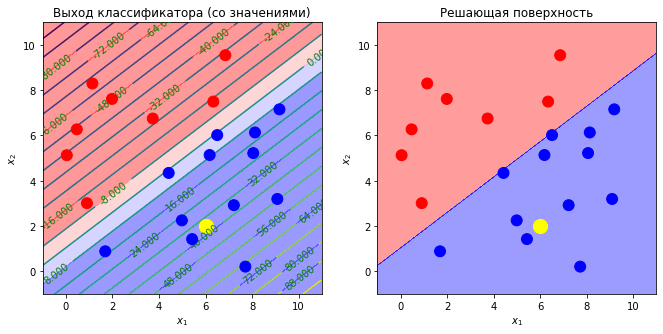

In [113]:
#@title 2 Подберите коэффициенты таким образом, чтобы значение в желтой точке (6, 2) было больше 20 при 100% точности{ run: "auto" } 

a = 7.5 #@param {type:"slider", min:-10, max:10, step:0.1}
b = -9.6 #@param {type:"slider", min:-10, max:10, step:0.1}
c = 10 #@param {type:"slider", min:-10, max:10, step:0.1}

n_lines = 27
clf = Neuron(a, b, c, False)

X, y = generate_simple_data(20, 1, -1, 0, 10, 10)

values, binary = create_two_axes()

show_descision_boundary(limits=limits, clf=clf, 
                            X=X,
                            y=y, 
                            n_lines=n_lines,
                            show_lines=True, ax=values)
show_descision_boundary(limits=limits, clf=clf, binary=True, 
                            X=X,
                            y=y, 
                            n_lines=n_lines,
                            show_lines=False, ax=binary)

values.scatter([6], [2], s=200, c="yellow", zorder=3)
binary.scatter([6], [2], s=200, c="yellow", zorder=3)
yellow_point = np.array([[6, 2]])
acc = eval_clf(clf, X, y)
value = clf(yellow_point)[0]
print(f"Classifier value at {yellow_point[0]}: {value}")
    
if acc != 1:
    print("Accuracy is too low (")
else:
    if value > 20:
        print("Well done")
    elif value > 10:
        print("Closer")
    elif value > 0:
        print("Try harder")

In [116]:
#@title Подсказка (нажать два раза)
# в этом задании менять направление не нужно -- точность уже максимальна. 
# значит, нужно найти способ менять значения в точках не меняя наклона
# обратите внимание, что значение в точке равно: ax1+bx2+c, в таком случае нормаль -- (a,b)
# попробуйте умножить все коэффициенты на положительную константу k, и вы получите нормаль (ka, kb) -- она смотрит в том же направлении!
# а значение функции изменится